In [1]:
# Import necessary libraries and functions
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import ssl
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import yfinance as yf
import re
import nltk
from nltk.corpus import stopwords

In [3]:
# Allow the user to input the stock ticker
ticker = input("Enter the stock ticker (e.g., AMD): ")

Enter the stock ticker (e.g., AMD):  meta


In [4]:
# Define a custom sentiment lexicon with finance-specific words
finance_lexicon = {
    'bullish': 1.0,
    'bearish': -1.0,
    'profit': 0.5,
    'loss': -0.5,
    'dividend': 0.3,
    'earnings': 0.3,
    'revenue': 0.2,
    'volatility': -0.2,
    'market': 0.1,
    'stock': 0.1,
    'shares': 0.1,
}

In [5]:
# Initialize the NLTK VADER sentiment analyzer
vader = SentimentIntensityAnalyzer()

In [6]:
# Function to perform custom sentiment analysis
def custom_sentiment_analyzer(text):
    compound_score = 0
    positive_words = []
    negative_words = []
    words = text.split()

    for word in words:
        if word in finance_lexicon:
            compound_score += finance_lexicon[word]
        else:
            sentiment_scores = vader.polarity_scores(word)
            compound_score += sentiment_scores['compound']
            if sentiment_scores['pos'] > sentiment_scores['neg']:
                positive_words.append(word)
            elif sentiment_scores['neg'] > sentiment_scores['pos']:
                negative_words.append(word)

    return compound_score, positive_words, negative_words

In [7]:
# Display the existing finance-related sentiment words
print("\nExisting finance-related sentiment words:")
for word, score in finance_lexicon.items():
    print(f"{word}: {score}")

# Function to manage the sentiment lexicon
def manage_lexicon():
    while True:
        print("\nSentiment Lexicon Management:")
        print("1. Add a sentiment word")
        print("2. Edit an existing sentiment word")
        print("3. Delete an existing sentiment word")
        print("4. Leave existing words as they are")
        print("5. Exit sentiment lexicon management")
        choice = input("Enter your choice: ")

        if choice == '1':
            word = input("Enter the sentiment word: ")
            score = float(input("Enter the sentiment score: "))
            finance_lexicon[word] = score
        elif choice == '2':
            word = input("Enter the sentiment word to edit: ")
            if word in finance_lexicon:
                score = float(input(f"Edit the sentiment score for {word}: "))
                finance_lexicon[word] = score
            else:
                print(f"{word} is not in the lexicon.")
        elif choice == '3':
            word = input("Enter the sentiment word to delete: ")
            if word in finance_lexicon:
                del finance_lexicon[word]
            else:
                print(f"{word} is not in the lexicon.")
        elif choice == '4':
            pass
        elif choice == '5':
            break
        else:
            print("Invalid choice. Please try again.")

# Allow the user to manage the sentiment lexicon
manage_lexicon()


Existing finance-related sentiment words:
bullish: 1.0
bearish: -1.0
profit: 0.5
loss: -0.5
dividend: 0.3
earnings: 0.3
revenue: 0.2
volatility: -0.2
market: 0.1
stock: 0.1
shares: 0.1

Sentiment Lexicon Management:
1. Add a sentiment word
2. Edit an existing sentiment word
3. Delete an existing sentiment word
4. Leave existing words as they are
5. Exit sentiment lexicon management


Enter your choice:  5


In [8]:
# Fetch news data from FinViz
finviz_url = "https://finviz.com/quote.ashx?t="
tickers = [ticker]
news_tables = {}
for ticker in tickers:
    url = finviz_url + ticker
    req = Request(url=url, headers={"user-agent": "SentimentAnalysis"})
    gcontext = ssl._create_unverified_context()
    res = urlopen(req, context=gcontext)
    html = BeautifulSoup(res, "lxml")
    table = html.find(id="news-table")
    news_tables[ticker] = table

In [9]:
# Process and store news data
parsed_data = []
for ticker, news_table in news_tables.items():
    for row in news_table.findAll("tr"):
        title = row.a.text if row.a is not None else "No title available"
        date_info = row.td.get_text()
        date_data = date_info.split()
        if len(date_data) == 1:
            if date_data[0] == "Today":
                current_date = datetime.now().strftime("%b-%d-%y")
                date = current_date
            else:
                time = datetime.strptime(date_data[0], '%I:%M%p').strftime('%H:%M')
        else:
            time = datetime.strptime(date_data[1], '%I:%M%p').strftime('%H:%M')
            date = date_data[0] if date_data[0] != "Today" else datetime.now().strftime("%b-%d-%y")
        compound_score, positive_words, negative_words = custom_sentiment_analyzer(title)
        parsed_data.append([ticker, time, date, title, compound_score, positive_words, negative_words])

In [10]:
# Create a pandas DataFrame
df = pd.DataFrame(parsed_data, columns=(["ticker", "time", "date", "title", "compound_score", "positive_words", "negative_words"]))

In [11]:
# Data Preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.split()
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

In [12]:
# Apply preprocessing to the title column
df["title"] = df["title"].apply(preprocess_text)

In [13]:
# Convert the date column to datetime format
df["date"] = pd.to_datetime(df["date"], format="%b-%d-%y").dt.date

In [14]:
# Group by date and ticker, and calculate the mean compound score
mean_df = df.groupby(['date', 'ticker'])['compound_score'].mean()
mean_df = mean_df.unstack()

In [16]:
# Set the display options to show all rows and columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# Print the DataFrame
print(df)

    ticker   time        date  \
0     meta  18:12  2023-11-08   
1     meta  17:19  2023-11-08   
2     meta  16:32  2023-11-08   
3     meta  16:21  2023-11-08   
4     meta  16:21  2023-11-08   
5     meta  13:58  2023-11-08   
6     meta  13:58  2023-11-08   
7     meta  10:53  2023-11-08   
8     meta  09:59  2023-11-08   
9     meta  08:20  2023-11-08   
10    meta  08:01  2023-11-08   
11    meta  06:07  2023-11-08   
12    meta  06:01  2023-11-08   
13    meta  06:01  2023-11-08   
14    meta  06:00  2023-11-08   
15    meta  06:00  2023-11-08   
16    meta  05:30  2023-11-08   
17    meta  05:30  2023-11-08   
18    meta  20:36  2023-11-07   
19    meta  15:44  2023-11-07   
20    meta  13:49  2023-11-07   
21    meta  12:47  2023-11-07   
22    meta  12:42  2023-11-07   
23    meta  09:32  2023-11-07   
24    meta  06:59  2023-11-07   
25    meta  06:05  2023-11-07   
26    meta  05:21  2023-11-07   
27    meta  21:06  2023-11-06   
28    meta  18:33  2023-11-06   
29    meta

In [17]:
# Define the date range based on sentiment data
start_date = mean_df.index.min()
end_date = mean_df.index.max()

In [18]:
# Fetch historical stock price data for the specified date range
stock_data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


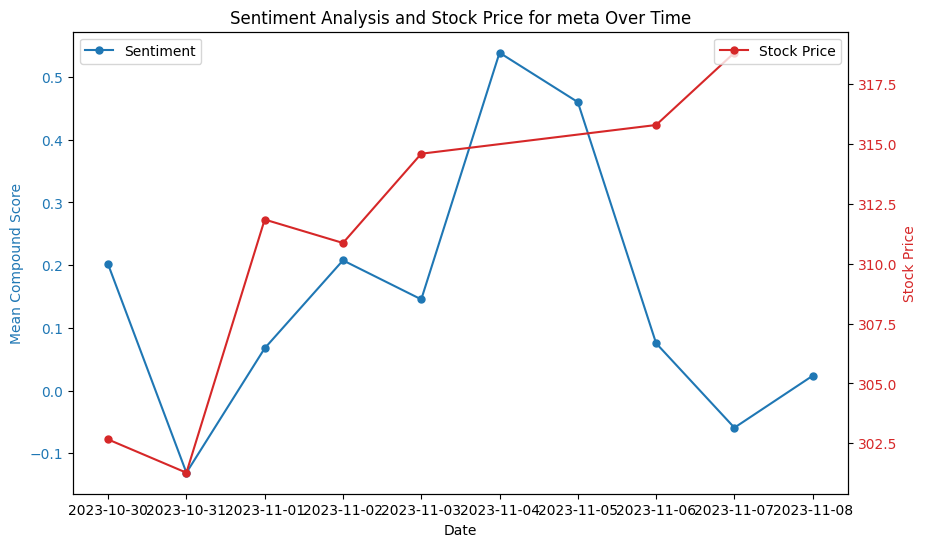

In [22]:
# Plot the sentiment data as a line chart
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.set_xlabel("Date")
ax1.set_ylabel("Mean Compound Score", color='tab:blue')
ax1.plot(mean_df.index, mean_df[ticker], color='tab:blue', marker='o', linestyle='-', markersize=5, label="Sentiment")
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

# Create a second y-axis for stock price data
ax2 = ax1.twinx()
ax2.set_ylabel("Stock Price", color='tab:red')
ax2.plot(stock_data.index, stock_data['Close'], color='tab:red', marker='o', linestyle='-', markersize=5, label="Stock Price")
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.legend(loc='upper right')

plt.title(f"Sentiment Analysis and Stock Price for {ticker} Over Time")
plt.show()